In [5]:
from huggingface_hub import notebook_login

notebook_login()

https://huggingface.co/docs/transformers/en/tasks/image_classification#image-classification

https://huggingface.co/docs/datasets/en/image_dataset

In [6]:
from PIL import Image



## Converting all images to jpg, and also renaming for simplicity

In [154]:
import os
files = os.listdir('classification_dataset/Broken_screen/')

files
ct = 1
for i in files:
    im = Image.open(f'classification_dataset/Broken_screen/{i}').convert("RGB")
    im.save(f"classification_dataset/broken_screen_conv/broken{ct}.png", "png")
    ct+=1

KeyboardInterrupt: 

In [ ]:
import os
files = os.listdir('classification_dataset/healthy_screen/')

files
ct = 1
for i in files:
    im = Image.open(f'classification_dataset/healthy_screen/{i}').convert("RGB")
    im.save(f"classification_dataset/healthy_screen_conv/healthy{ct}.png", "png")
    ct+=1

In [ ]:
import csv
healthy = os.listdir('classification_dataset/healthy_screen_conv/')
broken = os.listdir('classification_dataset/Broken_screen_conv/')
#with open('screen_metadata.csv', newline='') as csvfile:
f = open('screen_metadata.csv','w')
    #csvfile.write('file_name,broken')
f.write('file_name,broken')
f.write('\n')
for img in healthy:
        f.write(f'{img}, 0')
        f.write('\n')
for img in broken:
        f.write(f'{img}, 1')
        f.write('\n')
f.close()


In [7]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="classification_dataset/screens_ds_full")

Resolving data files:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
dataset.push_to_hub('dskong07/charging-screen-classification-dataset')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dskong07/charging-screen-classification-dataset/commit/b79ac2ee4d6f9a56e292689d5c6702f90006831e', commit_message='Upload dataset', commit_description='', oid='b79ac2ee4d6f9a56e292689d5c6702f90006831e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/dskong07/charging-screen-classification-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='dskong07/charging-screen-classification-dataset'), pr_revision=None, pr_num=None)

## Now getting from HF repo and stuff

In [8]:
screens = load_dataset("dskong07/charging-screen-classification-dataset")

In [9]:
screens = screens.shuffle(seed=1)
ds = screens["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
"""labels = screens["train"].features["broken"]

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):

    label2id[label] = str(i)

    id2label[str(i)] = label"""

id2label={0:'healthy',1:'broken'}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (

    image_processor.size["shortest_edge"]

    if "shortest_edge" in image_processor.size

    else (image_processor.size["height"], image_processor.size["width"])

)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
def transforms(examples):

    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]

    del examples["image"]

    return examples

In [ ]:
ds = ds.with_transform(transforms)

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer



model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
'''training_args = TrainingArguments(

    output_dir="screen-classif-model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,

)'''

'training_args = TrainingArguments(\n\n    output_dir="screen-classif-model",\n    remove_unused_columns=False,\n    eval_strategy="epoch",\n    save_strategy="epoch",\n    learning_rate=5e-5,\n    per_device_train_batch_size=16,\n    gradient_accumulation_steps=4,\n    per_device_eval_batch_size=16,\n    num_train_epochs=3,\n    warmup_ratio=0.1,\n    logging_steps=10,\n    load_best_model_at_end=True,\n    metric_for_best_model="accuracy",\n    push_to_hub=True,\n\n)'

In [155]:
training_args = TrainingArguments(
    output_dir="screen-classif-model",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    #warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)


In [156]:

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1,0.069000,0.384129,0.882353
2,0.057300,0.379157,0.882353
3,0.057700,0.454803,0.882353
4,0.044700,0.385754,0.882353
5,0.427400,0.450320,0.882353
6,0.123500,0.445381,0.882353
7,0.097600,0.420261,0.882353
8,0.168900,0.426597,0.882353
9,0.265900,0.465630,0.882353
10,0.134800,0.438511,0.882353


Could not locate the best model at screen-classif-model\checkpoint-83\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=170, training_loss=0.07008702385184519, metrics={'train_runtime': 799.4255, 'train_samples_per_second': 0.838, 'train_steps_per_second': 0.213, 'total_flos': 5.191963304177664e+16, 'train_loss': 0.07008702385184519, 'epoch': 10.0})

In [ ]:
trainer.push_to_hub()

In [2]:
from transformers import pipeline

classifier = pipeline("image-classification", model="screen-classif-model")


#classifier(image)

Device set to use cpu


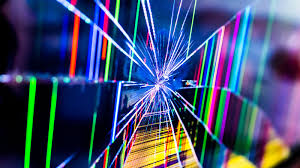

In [18]:
img_test = screens['train']['image'][0]
img_test

In [19]:
classifier(img_test)

[{'label': 'broken', 'score': 0.8725669384002686},
 {'label': 'healthy', 'score': 0.11355575174093246}]

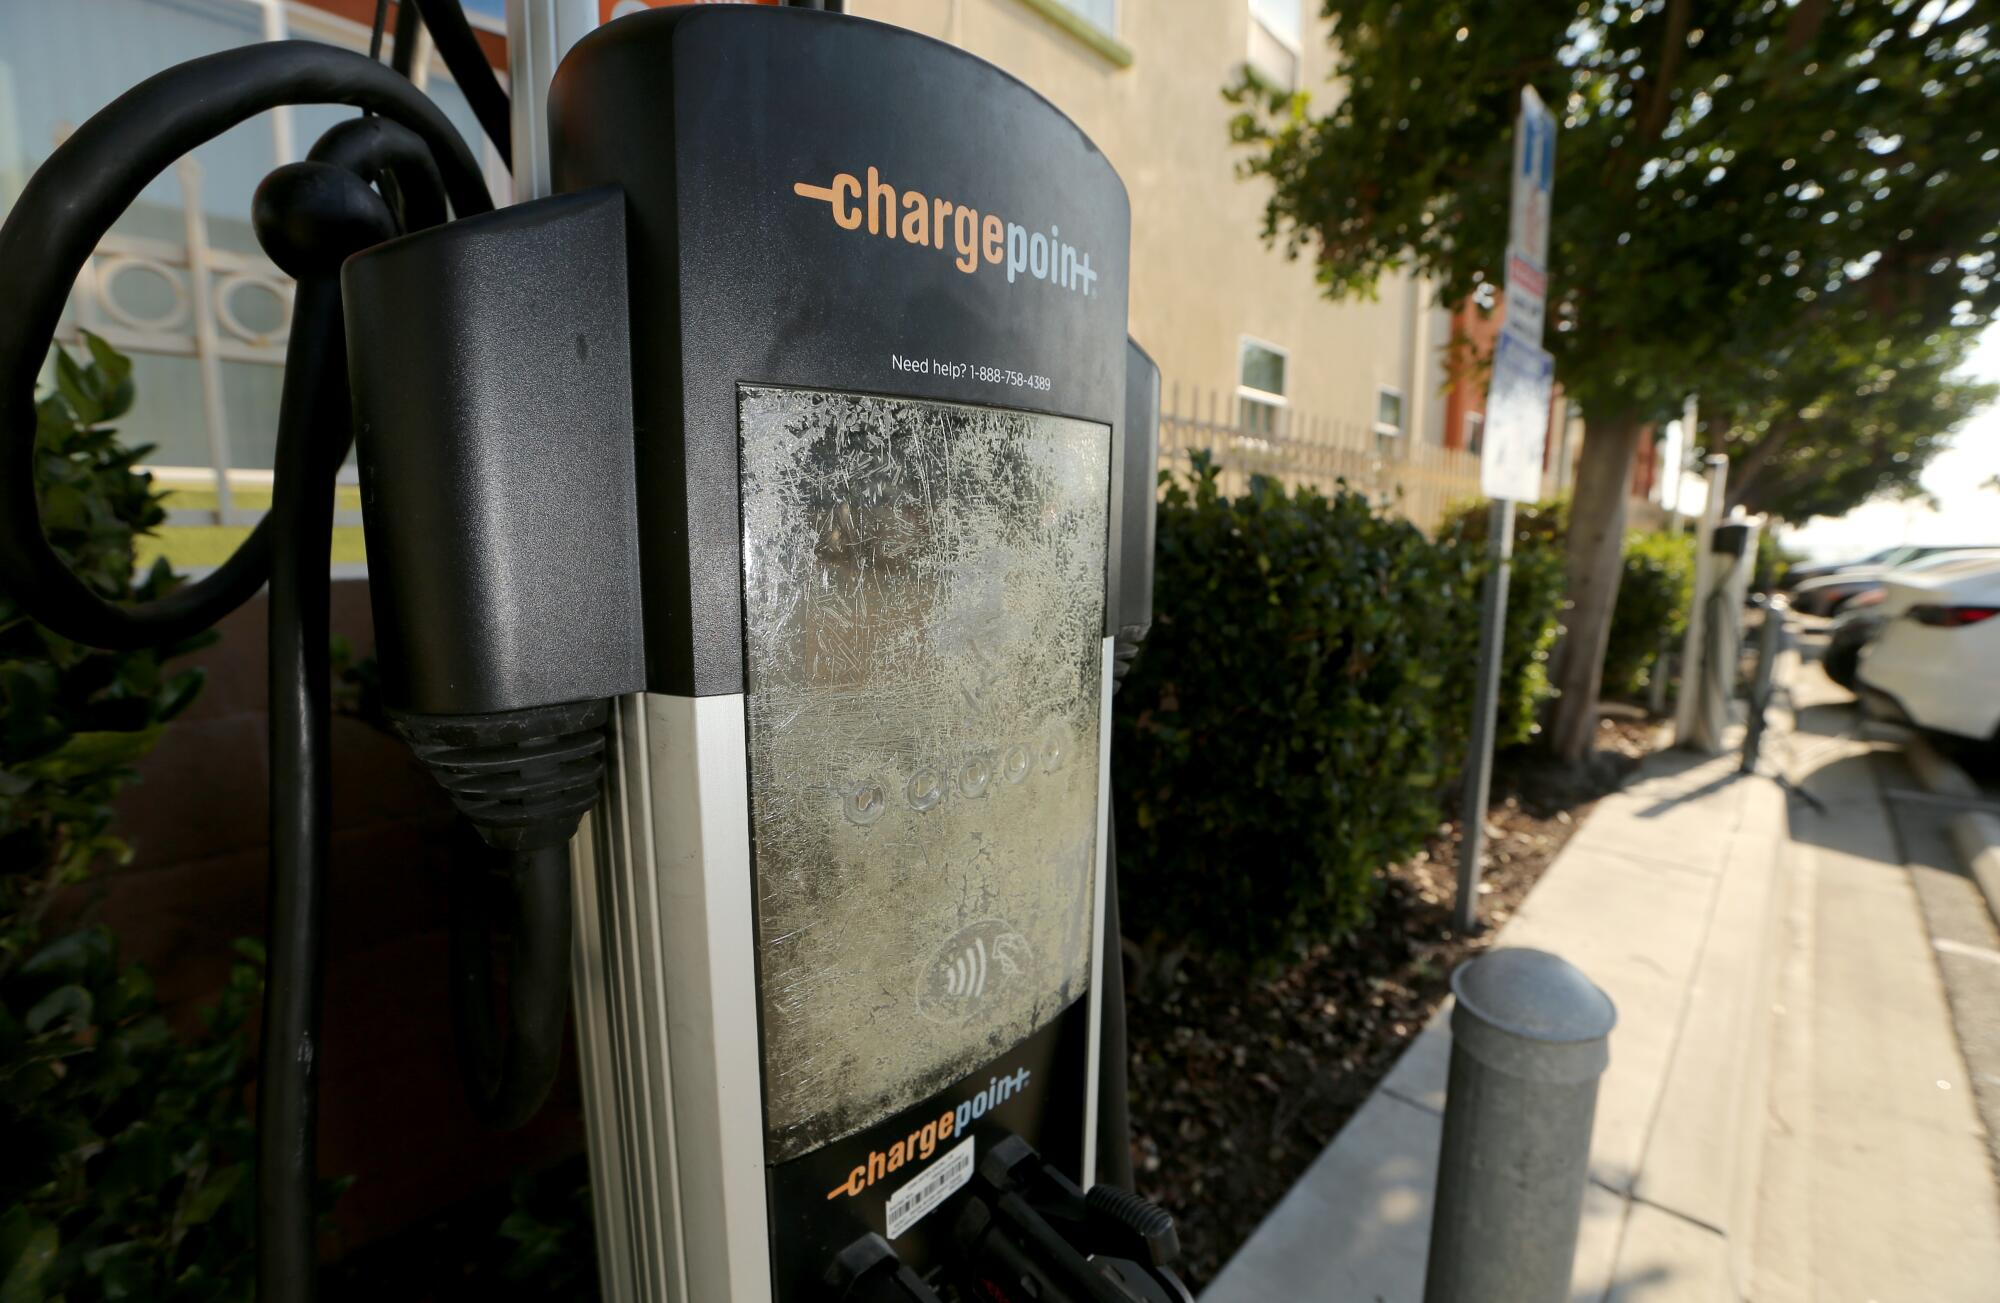

In [21]:
local_img = Image.open(fp='example_data/brokenscreen_example.png')
local_img

In [22]:
classifier(local_img)

[{'label': 'broken', 'score': 0.6918686628341675},
 {'label': 'healthy', 'score': 0.33627456426620483}]